In [2]:
import polars as pl
from nanomotif.binnary import data_processing

In [3]:
class Args():
    def __init__(self):
        self.bin_motifs = "../data/datasets/fragmentation_benchmark_20kb_1800kb_combined/bin-motifs.tsv"
        self.contig_bins = "../data/datasets/fragmentation_benchmark_20kb_1800kb_combined/contig_bin.tsv"
        self.assembly_file = "../data/datasets/fragmentation_benchmark_20kb_1800kb_combined/concatenated_assembly.fasta"
        self.min_valid_read_coverage = 3
        self.mean_methylation_cutoff = 0.5
        self.n_motif_bin_cutoff = 200
        self.n_motif_contig_cutoff = 8
        self.min_motif_comparisons = 2
        self.save_scores = False
        self.threads = 1

In [4]:
args = Args()
(
    bin_motifs,
    contig_bins,
) = data_processing.load_data(args)

In [5]:
assembly = data_processing.read_fasta(args.assembly_file)

In [6]:
contig_lengths = data_processing.find_contig_lengths(assembly)

In [9]:
contig_methylation = pl.read_csv(
            "../output/baseline/contamination_files/fragmentation_benchmark_20kb_1800kb_combined/motifs-scored-read-methylation-3.tsv", separator="\t", has_header = True
        )

In [8]:
contig_methylation = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )
binned_contig_methylation_imputed = data_processing.impute_contig_methylation_within_bin(
            contig_methylation,
            args
        )

In [14]:
import hdbscan


contig_methylation_bin = data_processing.add_bin(
            contig_methylation,
            contig_bins
        )

bins_with_single_contigs = contig_methylation_bin\
    .select(["bin", "contig"])\
    .unique()\
    .group_by("bin")\
    .agg(pl.col("contig").count().alias("n_contigs"))\
    .filter(pl.col("n_contigs") == 1)


contig_methylation_bin = contig_methylation_bin\
    .filter(~pl.col("bin").is_in(bins_with_single_contigs.get_column("bin")))

binned_contig_methylation_imputed = data_processing.impute_contig_methylation_within_bin(
            contig_methylation_bin,
            args
        )


contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5, metric="euclidean", allow_single_cluster=True)
hdbscan_labels = clusterer.fit_predict(matrix)

In [20]:
results = pl.DataFrame({
    "contig": contig_names,
    "cluster": hdbscan_labels
})

results

contig,cluster
str,i64
"""DSMZ107007-Anabaena_variabilis…",0
"""DSMZ107007-Anabaena_variabilis…",0
"""DSMZ107007-Anabaena_variabilis…",0
"""DSMZ107007-Anabaena_variabilis…",0
"""DSMZ107007-Anabaena_variabilis…",0
…,…
"""p_thermoglucosidasius_contig_2…",8
"""p_thermoglucosidasius_contig_3…",8
"""p_thermoglucosidasius_contig_3…",8


In [12]:
from sklearn.manifold import TSNE
import polars as pl

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

tsne = TSNE(n_components = 3, perplexity = 30, random_state=42, n_jobs=args.threads)
tsne_embedding = tsne.fit_transform(matrix)

contig_weight = contig_lengths\
    .filter(pl.col("contig").is_in(contig_names))\
    .with_columns(
        pl.col("length").log(base=10).alias("weight")
    )\
    .get_column("weight")

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3, n_jobs=args.threads)
dbscan.fit(tsne_embedding, sample_weight = contig_weight)
labels = dbscan.labels_

results = pl.DataFrame({
                            "contig": contig_names,
                            "cluster": labels
                        })

results = binned_contig_methylation_imputed\
    .select(["bin", "contig"])\
    .unique()\
    .join(results, on = "contig", how = "left")\
    .join(contig_lengths, on = "contig", how = "left")





KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
import polars as pl

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

pca = PCA(n_components = 5, random_state=42)
pca_embedding = pca.fit_transform(matrix)

contig_weight = contig_lengths\
    .filter(pl.col("contig").is_in(contig_names))\
    .with_columns(
        pl.col("length").log(base=10).alias("weight")
    )\
    .get_column("weight")

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=3, n_jobs=args.threads)
dbscan.fit(pca_embedding, sample_weight = contig_weight)
labels = dbscan.labels_

results = pl.DataFrame({
                            "contig": contig_names,
                            "cluster": labels
                        })

results = binned_contig_methylation_imputed\
    .select(["bin", "contig"])\
    .unique()\
    .join(results, on = "contig", how = "left")\
    .join(contig_lengths, on = "contig", how = "left")





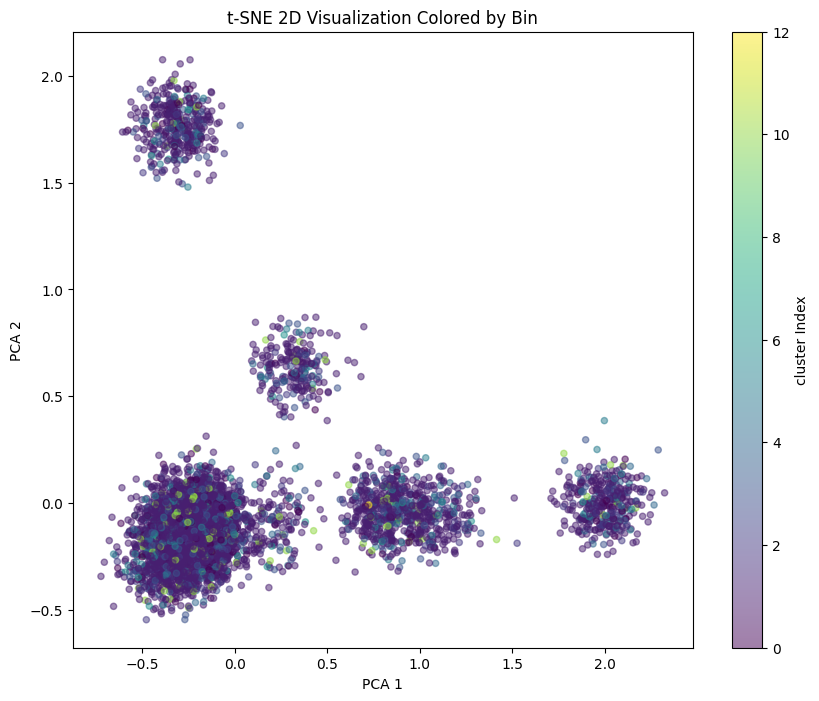

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Extract t-SNE 2D coordinates and bin labels
pca_coords = pca_embedding[:, :2]  # Use first two dimensions for 2D plot
bins = results.to_pandas()["bin"]  # Bin labels

# Convert bin labels to numerical values for coloring
# unique_bins = bins.unique()
# bin_to_color = {bin: i for i, bin in enumerate(unique_bins)}
# colors = bins.map(lambda bin: bin_to_color[bin])
colors = results.get_column("cluster")


jitter_amount = 0.1  # Adjust the jitter intensity
pca_coords_jittered = pca_coords + np.random.normal(0, jitter_amount, pca_coords.shape)
# Create scatter plot
plt.figure(figsize=(10, 8))
sc = plt.scatter(pca_coords_jittered[:, 0], pca_coords_jittered[:, 1], c=colors, cmap="viridis", s=20, alpha=0.5)

# Add colorbar and labels
cbar = plt.colorbar(sc)
cbar.set_label('cluster Index')
plt.title("PCA Visualization Colored by Bin")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.show()

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import hdbscan

contig_names, matrix = data_processing.create_matrix(binned_contig_methylation_imputed)

# Assume `matrix` is your methylation matrix
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)


# Compute k-nearest neighbors distance graph
dist_matrix = kneighbors_graph(
    matrix_scaled,  # Use scaled matrix
    n_neighbors=10,  # Adjust based on average bin size or experimentation
    mode="distance",  # Get distances instead of adjacency
    p=3,  # Euclidean distance (can adjust based on data characteristics)
    n_jobs=-1  # Use all available cores for efficiency
)

# Run HDBSCAN on the precomputed distance matrix
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=5, metric="precomputed", allow_single_cluster=True)
hdbscan_labels = clusterer.fit_predict(dist_matrix.toarray()) 

In [55]:
# unique_labels = np.unique(hdbscan_labels)
np.unique(hdbscan_labels)


array([0])

In [47]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
embedding_2d = pca.fit_transform(matrix_scaled)

# Reduce to 3D for optional 3D visualization
pca_3d = PCA(n_components=3, random_state=42)
embedding_3d = pca_3d.fit_transform(matrix_scaled)

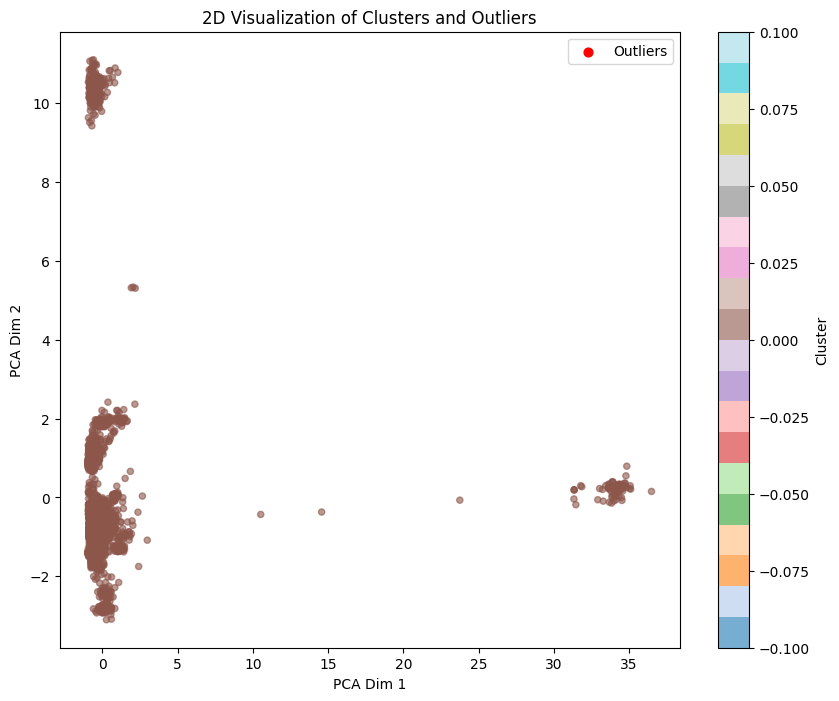

In [48]:
# Extract cluster labels
labels = hdbscan_labels

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embedding_2d[:, 0], 
    embedding_2d[:, 1], 
    c=labels, 
    cmap="tab20",  # Use a qualitative colormap
    s=20,          # Marker size
    alpha=0.6      # Transparency
)

# Highlight outliers (label == -1) with a distinct color
outliers = (labels == -1)
plt.scatter(
    embedding_2d[outliers, 0], 
    embedding_2d[outliers, 1], 
    c="red", 
    s=40, 
    label="Outliers"
)

# Add legend and title
plt.colorbar(scatter, label="Cluster")
plt.title("2D Visualization of Clusters and Outliers")
plt.xlabel("PCA Dim 1")
plt.ylabel("PCA Dim 2")
plt.legend()
plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    embedding_3d[:, 0], 
    embedding_3d[:, 1], 
    embedding_3d[:, 2], 
    c=labels, 
    cmap="tab20", 
    s=20, 
    alpha=0.6
)

# Highlight outliers
ax.scatter(
    embedding_3d[outliers, 0], 
    embedding_3d[outliers, 1], 
    embedding_3d[outliers, 2], 
    c="red", 
    s=40, 
    label="Outliers"
)

# Add title and legend
ax.set_title("3D Visualization of Clusters and Outliers")
ax.set_xlabel("PCA Dim 1")
ax.set_ylabel("PCA Dim 2")
ax.set_zlabel("PCA Dim 3")
plt.legend()
plt.show()
